# Exploratory Data Analysis of the Ocular Disease Recognition dataset

### What do I plan to do?
I want to take the inputs:
- Patient info (Age, Sex)
- Fundus imagery

and output a set of diagnostic keywords for their pathology

#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -e ../.

Obtaining file:///Users/lorcan/code/lorcanob/OcuPath
  Preparing metadata (setup.py) ... done


  Attempting uninstall: OcuPath
    Found existing installation: OcuPath 1.0
    Uninstalling OcuPath-1.0:
      Successfully uninstalled OcuPath-1.0
  Running setup.py develop for OcuPath


## DataFrame

In [3]:
#OcuPath
from OcuPath.dataframer import DataFramer

#DS
import sys
import os
import re
import math
import numpy as np
import pandas as pd

#EDA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [4]:
# Instanciate class and read data
dataframer = DataFramer()
data = dataframer.read_data()
dataframer.test()

Normal (N)


In [5]:
!pwd

/Users/lorcan/code/lorcanob/OcuPath/notebooks


In [6]:
# First and second round preparations of the dataframes
human_df = dataframer.get_human_df()
model_df = dataframer.get_model_df()

# Extract all keyphrases from Diagnostic
key_list = dataframer.get_key_list(model_df['Diagnostic Keywords'])

# To extract the jpg filename
left, right = dataframer.extract_jpg_names()

## Images

In [7]:
# Need to work on developing the custom encoder below
# Boilerplate OHE
def has_keyword_mentioned(text, keyword='cataract'):
    if keyword in text:
        return '1'
    else:
        return '0'

In [8]:
import PIL.Image
import tensorflow as tf
import pathlib

# Set image path
dataframer.set_image_path()

# Used to binary encode Cataract labels only for now
model_df['Cataract'] = model_df['Diagnostic Keywords'].map(has_keyword_mentioned)

# Remove instances of missing images for data
def remove_missing():
    true_images = os.listdir(dataframer.impath)
    temp_df = model_df[model_df['Image'].isin(true_images)]
    return temp_df

temp_df = remove_missing()

# Sort df based on alphameric image name
data_df = temp_df.sort_values(by=['Patient ID', 'Right Eye'])

In [11]:
model_df

,Patient Age,Patient Male,Image,Diagnostic Keywords,Right Eye,Cataract
Patient ID,,,,,,
0,69,0,0_right.jpg,normal fundus,1,0
0,69,0,0_left.jpg,cataract,0,1
1,57,1,1_right.jpg,normal fundus,1,0
1,57,1,1_left.jpg,normal fundus,0,0
2,42,1,2_right.jpg,moderate non proliferative retinopathy,1,0
...,...,...,...,...,...,...
4689,54,1,4689_left.jpg,mild nonproliferative retinopathy,0,0
4690,57,1,4690_left.jpg,mild nonproliferative retinopathy,0,0
4690,57,1,4690_right.jpg,mild nonproliferative retinopathy,1,0


In [10]:
dataframer.custom_OHE()

,Patient Age,Patient Sex,Image,Diagnostic Keywords,Eye,abnormal pigment,age-related macular degeneration,anterior segment image,arteriosclerosis,atrophic change,...,suspected moderate non proliferative retinopathy,suspected retinal vascular sheathing,suspicious diabetic retinopathy,tessellated fundus,vessel tortuosity,vitreous degeneration,vitreous opacity,wedge white line change,wet age-related macular degeneration,white vessel
Patient ID,,,,,,,,,,,,,,,,,,,,,
0,69,0,0_right.jpg,normal fundus,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,69,0,0_left.jpg,cataract,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,57,1,1_right.jpg,normal fundus,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,57,1,1_left.jpg,normal fundus,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,42,1,2_right.jpg,moderate non proliferative retinopathy,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4689,54,1,4689_left.jpg,mild nonproliferative retinopathy,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4690,57,1,4690_left.jpg,mild nonproliferative retinopathy,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4690,57,1,4690_right.jpg,mild nonproliferative retinopathy,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Compute Engine
DL Image

In [668]:
# Batching method using ImageDataGenerator
# Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=data_df,
    directory=pathlib.Path(dataframer.impath),
    x_col="Image",
    y_col="Cataract",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(512,512)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=data_df,
    directory=pathlib.Path(dataframer.impath),
    x_col="Image",
    y_col="Cataract",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(512,512)
)

Found 5114 validated image filenames belonging to 2 classes.
Found 1278 validated image filenames belonging to 2 classes.


In [679]:
# Build a baseline model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
import pandas as pd
import numpy as np

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(512,512,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))
model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

In [680]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10
102/159 [==================>...........] - ETA: 23:58 - loss: 0.0000e+00 - accuracy: 0.0536

KeyboardInterrupt: 

In [579]:
# Alternate method of batching using tf.data.Dataset.from_tensor_slices
filenames = tf.constant(dataframer.impath+os.sep+temp_df['Image'].values)
labels = tf.constant(temp_df.Cataract)

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

dataset = dataset.map(_parse_function)
dataset = dataset.batch(32)

# step 4: create iterator and final input tensor
iterator = iter(dataset)
images, labels = iterator.get_next()

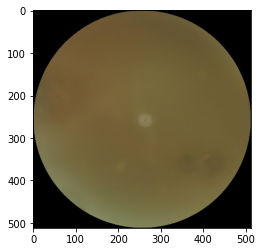

In [648]:
plt.imshow(np.array(train_generator[0][0][0]))

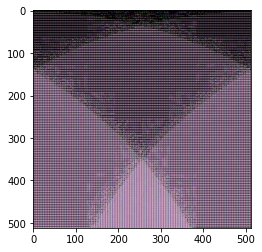

In [646]:
img = PIL.Image.fromarray(np.array(train_generator[0][0][0]), 'RGB')
plt.imshow(img)

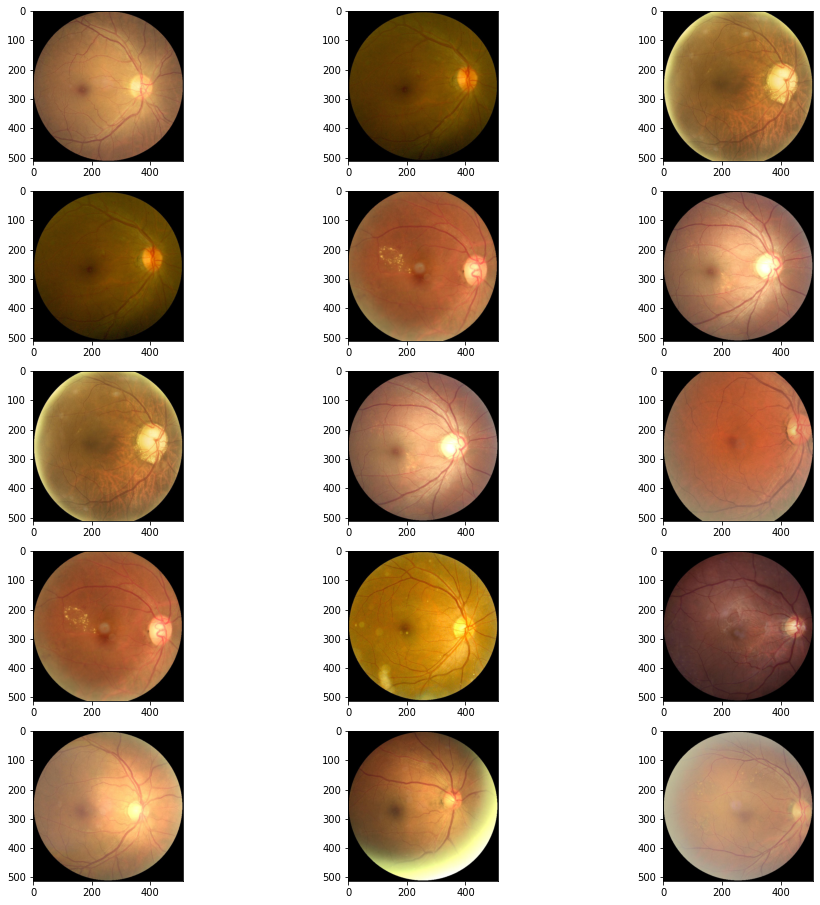

In [69]:
fig, axs = plt.subplots(5, 3, figsize=(16,16))

for i in range(5):
    for j in range(3):
        axs[i,j].imshow(plt.imread(f'../raw_data/preprocessed_images/{right[(i+1)*(j+1)]}'))